In [59]:
import pickle
import numpy as np 
import pandas as pd 
import os

plt.rcParams['font.family'] = 'sans-serif'
DATADIR = '../data/'
from sklearn.preprocessing import StandardScaler
import matplotlib.pylab as plt
from dispersant_screener.definitions import FEATURES

from pypal.models.gpr import predict_coregionalized

In [23]:
def load_data(n_samples, label_scaling: bool = False):
    """Take in Brian's data and spit out some numpy arrays for the PAL"""
    df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv'))[FEATURES].values
    a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
    deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values  # pylint:disable=unused-variable
    gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values * (-1)
    gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
    force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values  # pylint:disable=unused-variable
    rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
    y = np.hstack([rg.reshape(-1, 1), gibbs.reshape(-1, 1), gibbs_max.reshape(-1, 1)])
    assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

    feat_scaler = StandardScaler()
    X = feat_scaler.fit_transform(df_full_factorial_feat)

    if label_scaling:
        label_scaler = MinMaxScaler()
        y = label_scaler.fit_transform(y)

    #greedy_indices = get_maxmin_samples(X, n_samples)

    return X, y#, greedy_indice

In [24]:
X, y = load_data(1)

In [18]:
with open('../work/sweeps3/20201021-235927_dispersant_0.01_0.05_0.05_60-models.pkl', 'rb') as fh:
    models = pickle.load(fh)

In [36]:
selected = np.load('../work/sweeps3/20201021-235927_dispersant_0.01_0.05_0.05_60-selected.npy', allow_pickle=True)

In [41]:
selected = selected[-1]

In [26]:
means0, std0 = predict_coregionalized(models[0], X, 0)
means1, std1 = predict_coregionalized(models[0], X, 1)
means2, std2 = predict_coregionalized(models[0], X, 2)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


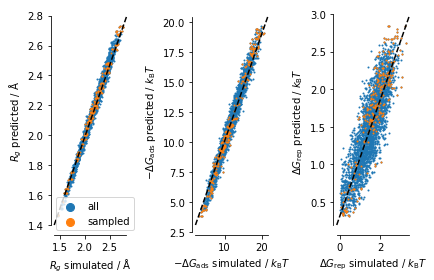

In [69]:
fig, ax = plt.subplots(1, 3)
ax[0].scatter(y[:,0], means0.flatten(), s=1, label='all')
ax[1].scatter(y[:,1], means1.flatten(), s=1)
ax[2].scatter(y[:,2], means2.flatten(), s=1)

ax[0].scatter(y[selected,0], means0.flatten()[selected], s=1, label='sampled')
ax[1].scatter(y[selected,1], means1.flatten()[selected], s=1)
ax[2].scatter(y[selected,2], means2.flatten()[selected], s=1)

ax[0].legend(markerscale=8)

ax[0].set_xlabel(r'$R_g$ simulated / $\mathrm{\AA}$')
ax[0].set_ylabel(r'$R_g$ predicted / $\mathrm{\AA}$')

ax[1].set_xlabel(r'$-\Delta G_\mathrm{ads}$ simulated / $k_\mathrm{B}T$')
ax[1].set_ylabel(r'$-\Delta G_\mathrm{ads}$ predicted / $k_\mathrm{B}T$')

ax[2].set_xlabel(r'$\Delta G_\mathrm{rep}$ simulated / $k_\mathrm{B}T$')
ax[2].set_ylabel(r'$\Delta G_\mathrm{rep}$ predicted / $k_\mathrm{B}T$')

for a in ax:
    a.plot(a.get_xlim(), a.get_ylim(), ls="--", c='k')
    a.spines['top'].set_color('none')
    a.spines['right'].set_color('none')
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)
    
fig.tight_layout()

fig.savefig('predictive_performance_models_pal.pdf', bbox_inches='tight')